In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = 'data/iMaterialist/'
sz=224

In [6]:
ls {PATH}

labels.csv                 test.json               train.json
labels.gz                  test.json.zip           train.json.zip
models/                    tmp/                    valid/
sample_submission.csv      train_10k/              validation.json
sample_submission.csv.zip  train_10kv2/            validation.json.zip
test/                      train_10kv2_labels.csv


In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

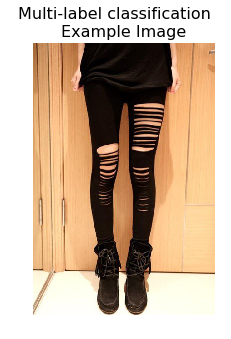

In [8]:
fn = get_1st(f'{PATH}train_10kv2')
plots_from_files([fn], titles=['Example Image'], maintitle="Multi-label classification")

In [59]:
from fastai.metrics import f1
metrics = [f1]
f_model = resnet34

In [60]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
val_idxs = get_cv_idxs(10000)
data = ImageClassifierData.from_csv(PATH, 'train_10kv2', f'{PATH}train_10kv2_labels.csv', tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

In [61]:
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=[f1])

100%|██████████| 621/621 [02:56<00:00,  3.52it/s]


## Step 1

First we begin retraining the last layer to map training images to our new labels. Because we do not need to send images through all but the last layer more than once, we turn on precompute to cache the vector embeddings before training the last fully connected logistic regression layer.

In [62]:
learn.lr_find(start_lr=1e-3, end_lr=1e3)

epoch      trn_loss   val_loss   f1         
    0      0.499256   0.804849   0.277605  



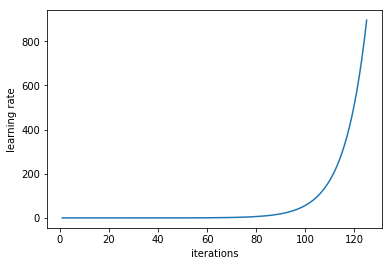

In [63]:
learn.sched.plot_lr()

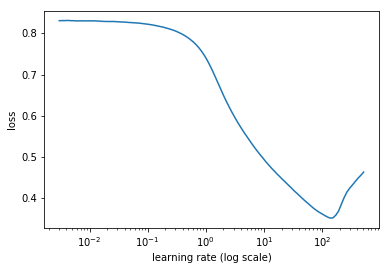

In [64]:
learn.sched.plot()

We started to see overfitting after 4 epochs. We will stop this initial training at 4 epochs

In [65]:
learn.fit(10, 4)

epoch      trn_loss   val_loss   f1         
    0      0.089106   0.072029   0.372183  
    1      0.073565   0.069693   0.392853  
    2      0.070378   0.068725   0.395922  
    3      0.068874   0.068441   0.36998   



[array([0.06844]), 0.36998024909864513]

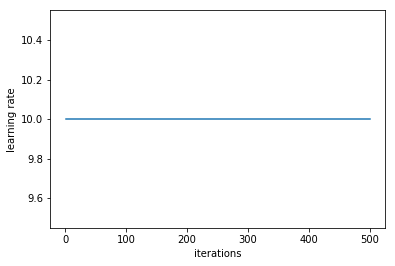

In [66]:
learn.sched.plot_lr()

## Step 2

Lets turn off precompute so we can use randomized crops / brightness levels / zooms for side-on image transformations. We will also add in some cycling of learning rates

In [67]:
learn.precompute=False

In [68]:
learn.fit(10, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.067848   0.066779   0.404572  
    1      0.067205   0.06656    0.400606  
    2      0.066619   0.06643    0.403842  



[array([0.06643]), 0.40384221752466326]

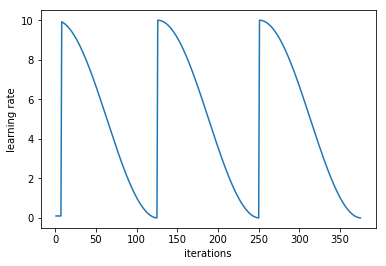

In [69]:
learn.sched.plot_lr()

## Step 3

Let's now tune the beginning, middle, and last layers with a couple more epochs and multiple the cycle len

I see significant overfitting after 2 cycles. May not need to use cycle_mult

In [70]:
learn.unfreeze()
lr=np.array([0.1, 1, 10])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.066856   0.064861   0.421183  
    1      0.06383    0.06345    0.442397  
    2      0.061958   0.063197   0.453488  



[array([0.0632]), 0.4534882236432194]

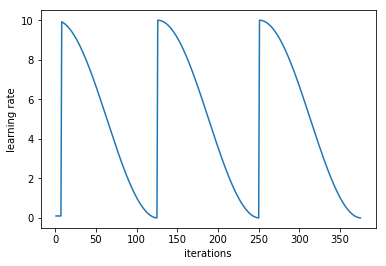

In [71]:
learn.sched.plot_lr()

## Step 4

Lets change the size so we avoid overfitting

epoch      trn_loss   val_loss   f1         
    0      0.059961   0.062859   0.463193  
    1      0.059573   0.062565   0.462607  
    2      0.058658   0.062491   0.465195  



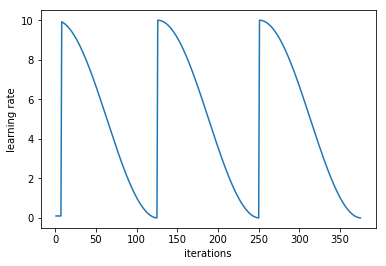

In [74]:
sz=299
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train_10kv2', f'{PATH}train_10kv2_labels.csv', tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)
learn.sched.plot_lr()

 96%|█████████▌| 120/125 [00:56<00:02,  2.13it/s, loss=0.255]

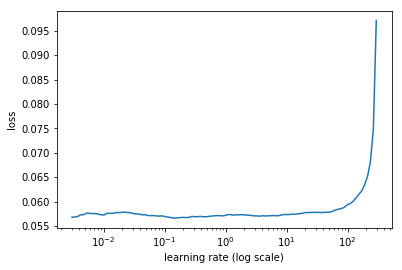

In [75]:
# Find next learning rate
learn.lr_find(start_lr=1e-3, end_lr=1e3)
learn.sched.plot()

In [76]:
learn.save('temp')

Now we want to unfreeze the earlier layers and retrain with larger images

  7%|▋         | 9/125 [00:08<01:49,  1.06it/s, loss=0.0589]
epoch      trn_loss   val_loss   f1         
    0      0.057382   0.062042   0.473421  
    1      0.056517   0.061897   0.471778  
    2      0.056094   0.061899   0.47985   



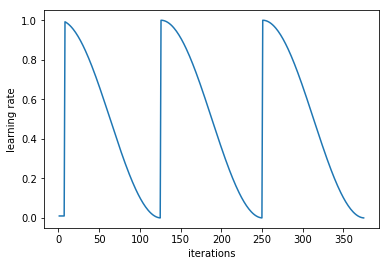

In [78]:
learn.unfreeze()
learn.fit([0.01, 0.1, 1.], 3, cycle_len=1)
learn.sched.plot_lr()

In [80]:
learn.save('resnet34_train_10kv2_0.47985')

In [79]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

In [243]:
test_ids = list(map(lambda x: x[5:-4], data.test_ds.fnames))

In [244]:
test_ids = pd.Series(map(lambda x: x[5:-4], data.test_ds.fnames), index=np.arange(len(data.test_ds.fnames)))

In [245]:
test_labels = pd.DataFrame(np.argwhere(preds > 0.5)).groupby(0)[1].apply(lambda s: s.astype(str).str.cat(sep=' '))

In [246]:
!head -10 /home/paperspace/data/iMaterialist/sample_submission.csv

image_id,label_id
1,106 115 126 145 161 176 185 32
2,115 13 14 158 18 184 190 220 227 44 47 56 81 9 92
3,104 112 129 224 31 83
4,113 121 145 150 218 63 77
5,1 126 167 170 196 208 213 216 22 32 48 54 79
6,108 110 132 20 4 50 54 6 68
7,144 187 202 205 215 23
8,171 199 21 38 50
9,113 123 128 159 186 199 228 35 38 47 80 86 95


In [247]:
subm = pd.concat([test_ids, test_labels], axis=1)
subm.columns = ['image_id', 'label_id']
subm['image_id'] = subm['image_id'].astype(int)
subm = subm.sort_values('image_id').reset_index(drop=True)

In [248]:
subm.head()

,image_id,label_id
0,1,7 75 125 187
1,2,75 187
2,3,77 93 109 187 193
3,4,42 59 69 98 173
4,5,59 77 187


# Get the right labels for first 10,000 images where urls match validation

In [171]:
ls /home/paperspace/data/iMaterialist/

labels.csv                 test.json               train.json
labels.gz                  test.json.zip           train.json.zip
models/                    tmp/                    valid/
sample_submission.csv      train_10k/              validation.json
sample_submission.csv.zip  train_10kv2/            validation.json.zip
test/                      train_10kv2_labels.csv


In [172]:
import json

In [249]:
with open('data/iMaterialist/test.json') as f:
    test_urls = pd.DataFrame(json.load(f)['images'])
    
with open('data/iMaterialist/validation.json') as f:
    j = json.load(f)
    valid_urls = pd.DataFrame(j['images'])
    valid_labels = pd.DataFrame(j['annotations'])
    valid_labels['labelId'] = valid_labels['labelId'].apply(lambda x: ' '.join(x))
    valid = valid_urls.merge(valid_labels, how='inner', on='imageId')[['url', 'labelId']]
test_labels = test_urls.merge(valid, how='inner', on='url').drop('url', axis=1)

In [250]:
test_labels.head()

,imageId,labelId
0,1,62 17 66 214 105 137 85
1,2,95 17 66 214 164 137 20 204 184
2,3,122 19 66 186 180 44 154 20
3,4,190 222 66 153 164 226 53 184
4,5,62 66 153 171 111 137 70 204 184


In [251]:
subm = subm.set_index('image_id')

In [252]:
subm.loc[test_labels['imageId'], 'label_id'] = test_labels['labelId'].values

In [255]:
subm = subm.reset_index()

In [260]:
subm.loc[9890:9900, :]

,image_id,label_id
9890,9891,193 222 66 164 53 175 87
9891,9892,62 17 66 171 153 20 204 184
9892,9893,189 66 111 180 176 20
9893,9894,33 117 106 53 184
9894,9895,190 113 153 164 222 53 184
9895,9896,18 66 222 131 205 105 44
9896,9897,95 17 66 25 226 222 153 164 59 181
9897,9898,57 179 187
9898,9899,75 77 125 187
9899,9900,8


In [264]:
subm.to_csv('data/iMaterialist/submission_resnet34_train_10kv2_0.47985.csv', index=False)

In [265]:
!head -10 /home/paperspace/data/iMaterialist/submission_resnet34_train_10kv2_0.47985.csv

image_id,label_id
1,62 17 66 214 105 137 85
2,95 17 66 214 164 137 20 204 184
3,122 19 66 186 180 44 154 20
4,190 222 66 153 164 226 53 184
5,62 66 153 171 111 137 70 204 184
6,62 66 153 105 14 17 98 20
7,12 66 214 171 111 137 70 175 54 138
8,62 66 116 222 105 14 176 137 53 20
9,56 66 171 111 210 137 184


In [266]:
!head -10 /home/paperspace/data/iMaterialist/sample_submission.csv

image_id,label_id
1,106 115 126 145 161 176 185 32
2,115 13 14 158 18 184 190 220 227 44 47 56 81 9 92
3,104 112 129 224 31 83
4,113 121 145 150 218 63 77
5,1 126 167 170 196 208 213 216 22 32 48 54 79
6,108 110 132 20 4 50 54 6 68
7,144 187 202 205 215 23
8,171 199 21 38 50
9,113 123 128 159 186 199 228 35 38 47 80 86 95
